In [2]:
"""
Some gerneral information:
We have data of time series with highly variable lengths, i.e., some patients might have dozens or even hundreds of CBC samples while their hospitilation. However, others might only have a few or even only 1 sample.
Therefore, we its a bit more difficult to implement time series deep learning approaches. 

Here, we will use masked padding, i.e., we will pad all sequences to the largest length and then will mask the padded results from the loss and auroc calculations using a bollean mask.
In my honest opinion this might be the best approach, since other approaches will have too high redundancies (creating time series for each sample with a label), less information for the prediction (truncation), wrong information (padding), or will have highly varying batch sizes (batching based on time series length)
"""

'\nSome gerneral information:\nWe have data of time series with highly variable lengths, i.e., some patients might have dozens or even hundreds of CBC samples while their hospitilation. However, others might only have a few or even only 1 sample.\nTherefore, we its a bit more difficult to implement time series deep learning approaches. \n\nHere, we will use masked padding, i.e., we will pad all sequences to the largest length and then will mask the padded results from the loss and auroc calculations using a bollean mask.\nIn my honest opinion this might be the best approach, since other approaches will have too high redundancies (creating time series for each sample with a label), less information for the prediction (truncation), wrong information (padding), or will have highly varying batch sizes (batching based on time series length)\n'

In [3]:
import sys
from dataAnalysis.DataAnalysis import DataAnalysis
import pandas as pd
import torch
from dataAnalysis.Constants import SEX_CATEGORY_COLUMN_NAME, SEX_COLUMN_NAME, FEATURES, LABEL_COLUMN_NAME
from sklearn.preprocessing import StandardScaler
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch.autograd import Variable 

In [4]:
data = pd.read_csv(r"sbcdata.csv", header=0)
data_analysis = DataAnalysis(data)

/home/dwalke/git/time_series/dataAnalysis/data/Filter.py:44: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  self.data['Label'].mask(control_filter, "Control", inplace=True)
/home/dwalke/git/time_series/dataAnalysis/data/Filter.py:45: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For

In [5]:
data = pd.concat((data_analysis.get_training_data(), data_analysis.get_testing_data()))
max_Id = data["Id"].unique().max()
gw_data = data_analysis.get_gw_testing_data().copy(deep=True)
gw_data = gw_data.assign(Id=lambda x: x.Id + max_Id)
data = pd.concat((data, gw_data))
data = data.sort_values(["Id", "Time"])
data = data.reset_index(drop=True)
popped_index = data.pop("index")

data[SEX_CATEGORY_COLUMN_NAME] = data.loc[:, SEX_COLUMN_NAME] =="W"
data[SEX_CATEGORY_COLUMN_NAME] = data[SEX_CATEGORY_COLUMN_NAME].astype("int8")
data["Label"] = data["Label"] == "Sepsis"
data["Label"] = data["Label"].astype("int8")


scaler = StandardScaler()
scaler.fit(data.loc[data["Set"] == "Training", FEATURES].values)

StandardScaler()

In [6]:
id_grouped_data = data.groupby("Id")


max_len = 0
for id, data_group in tqdm(id_grouped_data):
    max_len = max(max_len, data_group.shape[0])
unique_train_ids = data.loc[data["Set"] == "Training", "Id"].unique()
max_train_idx = int(len(unique_train_ids)*.8)
val_ids = unique_train_ids[max_train_idx:]

  0%|          | 0/866517 [00:00<?, ?it/s]

In [7]:
import numpy as np

pad_value = -10.0
TRAIN = "train"
GW = "gw_test"
TEST = "test"
VAL = "val"

features = dict({})
features[TRAIN] = []
features[VAL] = []
features[TEST] = []
features[GW] = []

labels = dict({})
labels[TRAIN] = []
labels[VAL] = []
labels[TEST] = []
labels[GW] = []

for id, data_group in tqdm(id_grouped_data):
    assert data_group["Set"].unique().shape[0] == 1
    assert data_group["Center"].unique().shape[0] == 1

    features_scaled = scaler.transform(data_group[FEATURES].values)

    padded_features = np.pad(features_scaled, ((0, max_len - data_group.shape[0]), (0,0)), mode='constant', constant_values=pad_value)
    padded_labels = np.pad(data_group[LABEL_COLUMN_NAME].values, ((0, max_len - data_group.shape[0])), mode='constant', constant_values=pad_value)
    
    first_el = data_group.iloc[0, :]
    if first_el["Set"] == "Training":
        if first_el["Id"] in val_ids:
            features[VAL].append(padded_features)
            labels[VAL].append(padded_labels)
            continue
        if first_el["Id"] not in val_ids:
            features[TRAIN].append(padded_features)
            labels[TRAIN].append(padded_labels)
            continue
    if first_el["Set"] == "Validation":
        if first_el["Center"] == "Greifswald":
            features[GW].append(padded_features)
            labels[GW].append(padded_labels)
            continue
        if first_el["Center"] == "Leipzig":
            features[TEST].append(padded_features)
            labels[TEST].append(padded_labels)
            continue

  0%|          | 0/866517 [00:00<?, ?it/s]

In [73]:
device = torch.device("cuda:1")

In [74]:
X_train = torch.from_numpy(np.stack(features[TRAIN])).type(torch.float32) #.to(device)
X_val = torch.from_numpy(np.stack(features[VAL])).type(torch.float32) # .to(device)
X_test = torch.from_numpy(np.stack(features[TEST])).type(torch.float32) #.to(device)
X_test_gw = torch.from_numpy(np.stack(features[GW])).type(torch.float32) #.to(device)

In [75]:
y_train = torch.from_numpy(np.stack(labels[TRAIN])).type(torch.float32) #.to(device)
y_val = torch.from_numpy(np.stack(labels[VAL])).type(torch.float32) #.to(device)
y_test = torch.from_numpy(np.stack(labels[TEST])).type(torch.float32) #.to(device)
y_test_gw = torch.from_numpy(np.stack(labels[GW])).type(torch.float32) #.to(device)

In [76]:
train_mask = y_train != pad_value
val_mask = y_val != pad_value
test_mask = y_test != pad_value
test_gw_mask = y_test_gw != pad_value

In [77]:
class Head(torch.nn.Module):

    def __init__(self, n_embd, head_size, dropout):
        super(Head, self).__init__()

        self.query = torch.nn.Linear(n_embd, head_size, bias=False)
        self.key = torch.nn.Linear(n_embd, head_size, bias = False)
        self.value = torch.nn.Linear(n_embd, head_size, bias = False)
        self.dropout = torch.nn.Dropout(dropout)

    def forward(self, x, ignore_mask):
        B,T,C = x.shape
        
        k = self.key(x)
        q = self.query(x)
        v = self.value(x)

        w = q@k.transpose(-2,-1)
        w = w* C**-.5
        w[ignore_mask] = float("-inf")
        w = torch.nan_to_num(torch.softmax(w, dim = -1))
        
        w = self.dropout(w)    
        out = w@v
        return out

class MultiHeadAttention(torch.nn.Module):

    def __init__(self, n_embd, num_heads, head_size, dropout):
        super(MultiHeadAttention, self).__init__()
        head_size = n_embd // num_heads
        self.heads = torch.nn.ModuleList([Head(n_embd, head_size, dropout) for _ in range(num_heads)])
        self.proj = torch.nn.Linear(head_size*num_heads, n_embd)
        self.dropout = torch.nn.Dropout(dropout)

    def forward(self, x, ignore_mask):
        out = torch.cat([h(x, ignore_mask) for h in self.heads], dim = -1)
        out = self.proj(out)
        out = self.dropout(out)
        return out

class FeedForward(torch.nn.Module):

    def __init__(self, n_embd, dropout):
        super(FeedForward, self).__init__()
        self.lin = torch.nn.Linear(n_embd, 4*n_embd)
        self.proj = torch.nn.Linear(4*n_embd, n_embd)
        self.dropout = torch.nn.Dropout(dropout)

    def forward(self, x):
        x = self.lin(x)
        x = torch.nn.functional.relu(x)
        x = self.proj(x)
        x = self.dropout(x)
        return x

class Block(torch.nn.Module):
    def __init__(self, n_embd, n_heads, dropout):
        super(Block, self).__init__()
        head_size = n_embd // n_heads

        self.sa_heads = MultiHeadAttention(n_embd, n_heads, head_size, dropout)
        self.ffwd = FeedForward(n_embd, dropout)
        self.layer_norm_1 = torch.nn.LayerNorm(n_embd)
        self.layer_norm_2 = torch.nn.LayerNorm(n_embd)

    def forward(self, x, ignore_mask):
        x = x + self.sa_heads(self.layer_norm_1(x), ignore_mask)
        x = x + self.ffwd(self.layer_norm_2(x))
        return x

class TransformerModel(nn.Module):

    def __init__(self, input_dim, n_embd, n_heads, dropout, n_blocks):
        super(TransformerModel, self).__init__()

        self.lin_input = nn.Linear(input_dim, n_embd)
        self.pos_embedding_table = nn.Embedding(max_len, n_embd)
        
        self.blocks = []
        for _ in range(n_blocks):
            self.blocks.append(Block(n_embd, n_heads, dropout).to(device)) #nn.Sequential(*[Block(n_embd, n_heads, dropout) for _ in range(n_blocks)], nn.LayerNorm(n_embd))
        # self.lm_head = nn.Linear(n_embd, vocab_size)
        # self.sa = Head(head_size)
        self.lin = nn.Linear(n_embd, 1)

    def forward(self, x, targets = None):
        B, T, C = x.shape
        pad_mask = (x != pad_value).type(torch.float)
        ignore_mask = torch.bmm(pad_mask, pad_mask.transpose(-2,-1))
        ignore_mask = ignore_mask == 0
        
        x = self.lin_input(x)
        pos_emb = self.pos_embedding_table(torch.arange(T, device = device))
        x = x + pos_emb

        for block in self.blocks:
            x = block(x, ignore_mask)
        logits = self.lin(x)
        
        return logits

In [101]:
n_embd, n_heads, dropout, n_blocks = 32, 4, 0.0, 2
model = TransformerModel(X_train.shape[-1], n_embd, n_heads, dropout, n_blocks).to(device)
lr = 3e-3
wd = 0.0
epochs = 100
eval_iter = 1
auroc_iter = 10
batch_size = 128
EARLY_STOP = 5
shuffle = False
weight = y_train[train_mask].numel() / y_train[train_mask].sum()

In [102]:
model(X_test[:100].to(device)).shape

torch.Size([100, 416, 1])

In [103]:
loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight= torch.tensor(weight), reduction="mean")

/tmp/ipykernel_245507/3361492951.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight= torch.tensor(weight), reduction="mean")


In [104]:
optim = torch.optim.Adam(params=model.parameters(), lr = lr, weight_decay=wd)

In [105]:
from sklearn.metrics import roc_auc_score
def test_auroc(dataloader, model):
    acc_proba = []
    acc_labels = []
    
    with torch.inference_mode():
        model.eval()
        for data, mask, labels in dataloader:
            data, mask, labels = data.to(device), mask.to(device), labels.to(device)
            out = model(data).squeeze(-1)[mask]
            out = torch.sigmoid(out)
    
            acc_proba.append(out.cpu().numpy())
            acc_labels.append(labels[mask].cpu().numpy())

    np_labels = np.concatenate(acc_labels, axis = 0)
    np_proba = np.concatenate(acc_proba, axis = 0)
    auroc = roc_auc_score(np_labels, np_proba)
    return auroc 

In [106]:
def test(dataloader, model):
    acc_loss = 0
    batch_size = 0
    
    with torch.inference_mode():
        model.eval()
        for data, mask, labels in dataloader:
            data, mask, labels = data.to(device), mask.to(device), labels.to(device)
            out = model(data).squeeze(-1)[mask]
            loss = loss_fn(out, labels[mask])

            acc_loss += loss.item()
            batch_size += labels[mask].shape[0]
            del data
            del mask
            del labels
    return acc_loss / batch_size

In [107]:
def train(dataloader, model, optim):
    model.train()
    acc_loss = 0
    batch_size = 0
    
    for data, mask, labels in dataloader:
        data, mask, labels = data.to(device), mask.to(device), labels.to(device)
        loss = loss_fn(model(data).squeeze(-1)[mask], labels[mask])
        optim.zero_grad()
        loss.backward()
        optim.step()
        
        acc_loss += loss.item()
        batch_size += labels[mask].shape[0]
        del loss 
        del data
        del mask
        del labels
    return acc_loss / batch_size

In [108]:
class Data(Dataset):
    def __init__(self, X, mask, labels):
        self.X = X
        self.mask = mask
        self.y = labels

    def __len__(self):
        return len(self.X)


    def __getitem__(self, idx):
        return self.X[idx], self.mask[idx], self.y[idx]

In [109]:
store = dict()
store[TRAIN] = DataLoader(Data(X_train, train_mask, y_train), batch_size= batch_size, shuffle = shuffle)
store[VAL] = DataLoader(Data(X_val, val_mask, y_val), batch_size= batch_size, shuffle = shuffle) 
store[TEST] = DataLoader(Data(X_test, test_mask, y_test), batch_size= batch_size, shuffle = shuffle)
store[GW] = DataLoader(Data(X_test_gw, test_gw_mask, y_test_gw), batch_size= batch_size, shuffle = shuffle) 

In [110]:
sets = (TRAIN, VAL, TEST, GW)

In [111]:
losses = dict()
for set in sets:
    losses[set] = []

In [112]:
for epoch in tqdm(range(50)):
    loss = train(store[TRAIN], model, optim)
    if epoch % eval_iter == 0:
        for set in sets:
            loss = test(store[set], model)
            losses[set].append(loss)
        if len(losses[VAL]) >= EARLY_STOP and np.mean(losses[VAL][-EARLY_STOP:]) < losses[VAL][-1]:
            print(f"Breaked at {epoch}")
            break

  0%|          | 0/50 [00:00<?, ?it/s]

Breaked at 24


In [113]:
for set in sets:
    print(f"{set}: f{test_auroc(store[set], model)}")

train: f0.9457983378035273
val: f0.908432713135715
test: f0.9139359105096847
gw_test: f0.9043579048365493


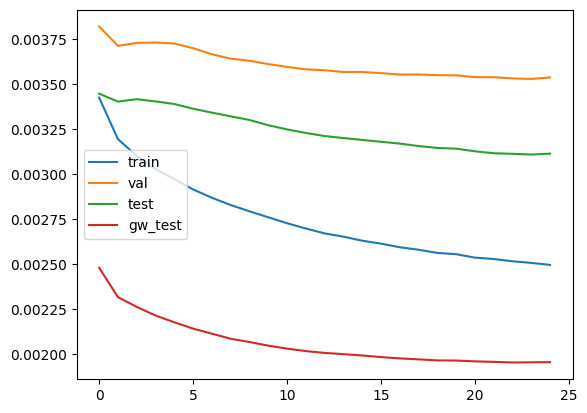

In [114]:
import matplotlib.pyplot as plt

for set in sets:
    plt.plot(losses[set])
plt.legend(sets)

In [143]:
class HyperParam:
    def __init__(self, lr, wd, n_embd, n_heads, dropout, n_blocks):
        self.hidden_dim = n_embd
        self.lr = lr
        self.wd = wd
        self.n_heads = n_heads
        self.dropout = dropout
        self.n_blocks = n_blocks

    def __repr__(self):
        return f"""
        hidden_dim: {self.hidden_dim},
        lr: {self.lr},
        wd: {self.wd},
        n_heads: {self.n_heads},
        dropout: {self.dropout},
        n_blocks: {self.n_blocks},
        """

In [147]:
hyper_params = []

hidden_dims = [32, 64]
lrs = [1e-3]
wds = [0]
heads_list = [2, 4]
dropouts = [0.0, 0.2]
blocks_list = [2, 3]

for hidden_dim in hidden_dims:
    for lr in lrs:
        for wd in wds:
            for heads in heads_list:
                for dropout in dropouts:
                    for blocks in blocks_list:
                        hyper_param = HyperParam(lr, wd, hidden_dim, heads, dropout, blocks)
                        hyper_params.append(hyper_param)

In [148]:
len(hyper_params)

16

In [149]:
eval_iter = 1
batch_size = 128
EARLY_STOP = 5
epochs = 100

def train_loop(model, optim, tracked_losses = [VAL]):
    losses = dict()
    for set in tracked_losses:
        losses[set] = []
    for epoch in tqdm(range(epochs)):
        loss = train(store[TRAIN], model, optim)
        if epoch % eval_iter == 0:
            for set in tracked_losses:
                loss = test(store[set], model)
                losses[set].append(loss)
            if len(losses[VAL]) >= EARLY_STOP and np.mean(losses[VAL][-EARLY_STOP:]) < losses[VAL][-1]:
                print(f"Breaked at {epoch}")
                break
    return losses[VAL]

In [150]:
import copy

best_val_loss = float("inf")
best_model = None
best_hyperparams = None
for hyper_param in tqdm(hyper_params):
    n_embd, n_heads, dropout, n_blocks = 32, 4, 0.0, 2
    model = TransformerModel(X_train.shape[-1], hyper_param.hidden_dim, hyper_param.n_heads, hyper_param.dropout, hyper_param.n_blocks).to(device)
    optim = torch.optim.Adam(params=model.parameters(), lr = hyper_param.lr, weight_decay=hyper_param.wd)
    val_losses = train_loop(model, optim)
    if best_val_loss >= val_losses[-1]:
        best_val_loss = val_losses[-1]
        best_model = copy.deepcopy(model.cpu())
        best_hyperparams = hyper_param

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Breaked at 8


  0%|          | 0/100 [00:00<?, ?it/s]

Breaked at 6


  0%|          | 0/100 [00:00<?, ?it/s]

Breaked at 6


  0%|          | 0/100 [00:00<?, ?it/s]

Breaked at 5


  0%|          | 0/100 [00:00<?, ?it/s]

Breaked at 6


  0%|          | 0/100 [00:00<?, ?it/s]

Breaked at 6


  0%|          | 0/100 [00:00<?, ?it/s]

Breaked at 4


  0%|          | 0/100 [00:00<?, ?it/s]

Breaked at 9


  0%|          | 0/100 [00:00<?, ?it/s]

Breaked at 5


  0%|          | 0/100 [00:00<?, ?it/s]

Breaked at 6


  0%|          | 0/100 [00:00<?, ?it/s]

Breaked at 5


  0%|          | 0/100 [00:00<?, ?it/s]

Breaked at 5


  0%|          | 0/100 [00:00<?, ?it/s]

Breaked at 37


  0%|          | 0/100 [00:00<?, ?it/s]

Breaked at 42


  0%|          | 0/100 [00:00<?, ?it/s]

Breaked at 8


  0%|          | 0/100 [00:00<?, ?it/s]

Breaked at 5


In [151]:
for set in sets:
    print(f"{set}: f{test_auroc(store[set], best_model.to(device))}")

train: f0.9557591403069645
val: f0.9155832784567111
test: f0.9256721637571632
gw_test: f0.9207581405384795


In [152]:
best_hyperparams


        hidden_dim: 64,
        lr: 0.001,
        wd: 0,
        n_heads: 4,
        dropout: 0.0,
        n_blocks: 2,
        

In [145]:
f"""hidden_dim: {best_hyperparams.hidden_dim},
lr: {best_hyperparams.lr},
wd: {best_hyperparams.wd},
n_heads: {best_hyperparams.n_heads},
dropout: {best_hyperparams.dropout},
n_blocks: {best_hyperparams.n_blocks}"""

'hidden_dim: 32,\nlr: 0.001,\nwd: 0,\nn_heads: 2,\ndropout: 0.0,\nn_blocks: 2'

In [146]:
best_model

TransformerModel(
  (lin_input): Linear(in_features=7, out_features=32, bias=True)
  (pos_embedding_table): Embedding(416, 32)
  (lin): Linear(in_features=32, out_features=1, bias=True)
)